# Tripartite with excitatory STDP

On the excitatory synapses

In [61]:
from brian2 import *
%matplotlib notebook

In [62]:
# from IPython.display import clear_output

In [63]:
# Constants
tau = 10*ms
I = 1.1/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  #should be > the threshold of firing

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) 
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''

In [64]:
start_scope()

n_i = 90 # 3 groups of n_i/3
n_e = 30

seed(21)

Gi = NeuronGroup(n_i, eqs2, threshold='v>1', reset='v = 0', method='exact')
Ge = NeuronGroup(n_e, eqs2, threshold='v>1', reset='v = 0', method='exact')

group1init = randint(0, 9, size=n_i)/10
group2init = randint(0, 9, size=n_e)/10

Gi.v = group1init
Ge.v = group2init

In [65]:
matrix = zeros((n_i, n_i))

def matcon(i,j):
        matrix[i, j] = 1

# each group of 30 to everything else
for i in range(n_i//3):
        for j in range(n_i//3, n_i):
                matcon(i,j)
for i in range(n_i//3, 2*n_i//3):
        for j in range(2*n_i//3, n_i):
                matcon(i,j)
        for j in range(0, n_i//3):
                matcon(i,j)
for i in range(2*n_i//3, n_i):
        for j in range(0, 2*n_i//3):
                matcon(i,j)

In [66]:
# imshow(matrix, origin='lower');

In [67]:
inh = 0.01
exc = 0.01

p = 0.8
exc_matrix = choice(2, (n_e, n_i), p=[1-p, p])
inh_matrix = exc_matrix.T



si, ti = matrix.nonzero()
se, te = exc_matrix.nonzero()
si2, ti2 = inh_matrix.nonzero()

In [68]:
# imshow(exc_matrix, origin='lower');

In [69]:
# imshow(inh_matrix, origin='lower');

In [70]:
tau_stdp = 100*ms
# gmax = .01
# dApre = .01
# dApost = -dApre * taupre / taupost * 1.05
# dApost *= gmax
# dApre *= gmax

gmax = 1.0


I1 = Synapses(Gi, Gi,
              '''w : 1
              dApre/dt = -Apre/tau_stdp : 1 (event-driven)
              dApost/dt = -Apost/tau_stdp : 1 (event-driven)
              ''', 
              on_pre='''Apre += 0.4
              w = clip(w + Apost, 0, gmax)
              v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh*w)/curr)))/tp))''',
              on_post='''Apost -= 0.4
              w = clip(w + Apre, 0, gmax)
              ''')

# Excitatory synapses
E1 = Synapses(Ge, Gi,
              on_pre='''
              v = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc)/curr)))/tp))''')

# Inhibitory recurrent synapses
I2 = Synapses(Gi, Ge,
              '''w : 1
              dApre/dt = -Apre/tau_stdp : 1 (event-driven)
              dApost/dt = -Apost/tau_stdp : 1 (event-driven)
              ''', 
              on_pre='''Apre += 0.4
              w = clip(w + Apost, 0, gmax)
              v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh*w)/curr)))/tp))''',
              on_post='''Apost -= 0.4
              w = clip(w + Apre, 0, gmax)
              ''')


I1.connect(i=si, j=ti)

E1.connect(i=se, j=te)

I2.connect(i=si2, j=ti2)

M1 = StateMonitor(Gi, 'v', record=True)
Sp1 = SpikeMonitor(Gi)
Wmon = StateMonitor(I1, 'w', record=True)
# I1.w = 'rand() * gmax'
# E1.w = 'rand() * gmax'
# I2.w = 'rand() * gmax'

In [71]:
run(800*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: '_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: '_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)'
 [brian2.codegen.generators.base]


<IPython.core.display.Javascript object>


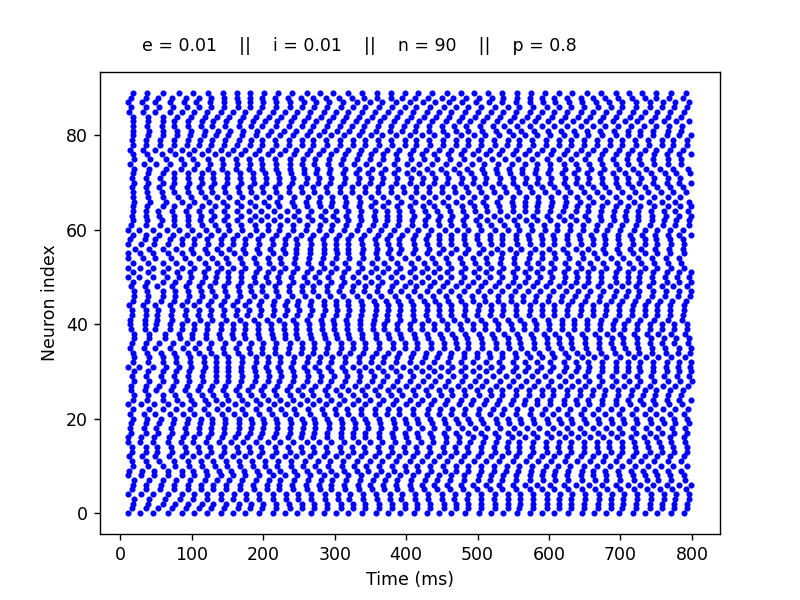

In [82]:
plot(Sp1.t/ms, Sp1.i, '.b', markersize=5)
xlabel('Time (ms)')
ylabel('Neuron index')
text(30, n_i+8, 'e = {}    ||    i = {}    ||    n = {}    ||    p = {}'.format(exc, inh, n_i, p))
show()

In [73]:
# hist(I2.w / gmax, 20)
# xlabel('Outer Inh Weights / gmax');

In [74]:
# hist(I1.w / gmax, 20)
# xlabel('Inner Inh Weights / gmax');

In [75]:
# shape(Wmon.w[:, 7000]) #synapses * time

In [76]:
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


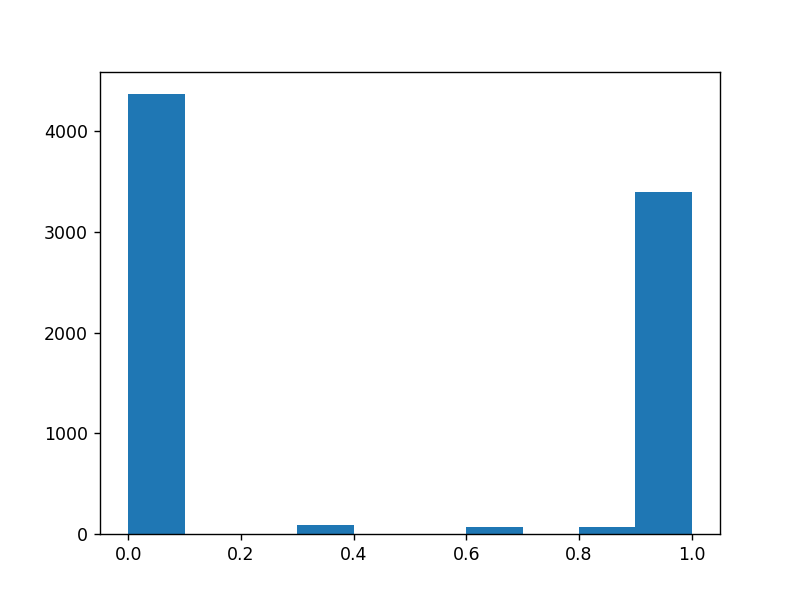

In [81]:
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)

# def animate(frame_num):
#     clf()
#     timer = frame_num
#     hist(Wmon.w[:,timer], 20)
#     xlabel('Weight / gmax')

# anim = FuncAnimation(fig, animate, frames=1000, interval=1)
# show()
# Wmon.w[:,num] = data[num]
%matplotlib notebook
from matplotlib.animation import FuncAnimation
data = Wmon.w #shape(A x 8000 = running time)
number_of_frames = 8000

def update_hist(num, data):
    plt.cla()
    plt.hist(data[num])

fig = plt.figure()
hist = plt.hist(data[0])

animation = FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ))
plt.show()

<IPython.core.display.Javascript object>


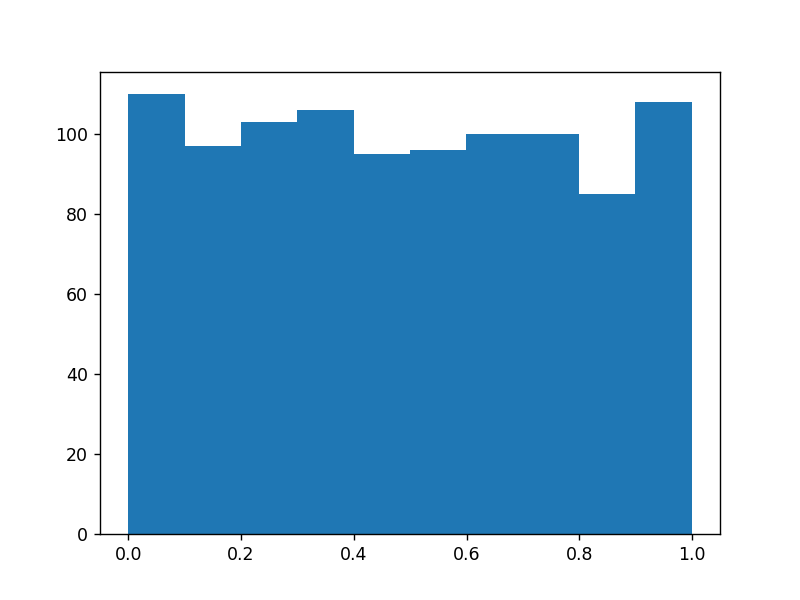

In [78]:
%matplotlib notebook
n = 100
number_of_frames = 1000
data = np.random.rand(n, number_of_frames)

def update_hist(num, data):
    plt.cla()
    plt.hist(data[num])

fig = plt.figure()
hist = plt.hist(data[0])
animation = FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ) )
plt.show()

In [79]:
shape(data)

(100, 1000)

In [80]:
data[200]

IndexError: index 200 is out of bounds for axis 0 with size 100

In [ ]:
shape(Wmon.w)

In [ ]:
Wmon.w[6000]

In [ ]:
# 5400 synapses over 8000 timepoints

In [ ]:
# hist(Wmon.w[:,5000], 20)
# xlabel('Weight / gmax')
# n_iterations = 500

# for i in range(n_iterations):
#     clear_output(wait=True)
#     hist(Wmon.w[:,i], 20)
#     xlabel('Weight / gmax')
# show()

In [ ]:
# from matplotlib.animation import FFMpegWriter
# %matplotlib inline
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# metadata = dict(title='randomseed', artist='k')
# writer = FFMpegWriter(fps=60, metadata=metadata)

# with writer.saving(fig, "gameoflife.gif", 100):
#     for tval in range(0,1000):
#         ax.plot(yf[0:tval,0],yf[0:tval,1],yf[0:tval,2])
#         writer.grab_frame()